# Facemask Detection Using YOLOv8: A Real-Time Implementation

## Import libraries and verifying

In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tqdm
import torch
import os
import glob

print("All libraries installed successfully!")

All libraries installed successfully!


In [2]:
!where python

c:\Users\ASUS_USER\anaconda3\envs\yolo-facemask\python.exe
C:\Python313\python.exe
C:\Users\ASUS_USER\AppData\Local\Programs\Python\Python312\python.exe


In [3]:
# Check if YOLOv8 is installed
import ultralytics
print(ultralytics.__version__)  # Must return a valid version (e.g., 8.x.x)

8.3.94


In [4]:
import torch
print(torch.__version__)  # Check installed version
print(torch.cuda.is_available())  # Check if GPU (CUDA) is available

2.6.0+cpu
False


Verify number of dataset

In [5]:
dataset_path = "C:/NaqibWorks/project/Yolo/dataset/images"

# Check if dataset folder exists
if os.path.exists(dataset_path):
    print("Dataset folder found.")
    image_count = len(glob.glob(os.path.join(dataset_path, "*.jpg")))
    print(f"Total images found: {image_count}")
else:
    print("Dataset folder not found! Please check the path.")


Dataset folder found.
Total images found: 1185


# **Recap of Preprocessing & Visualization Steps:**
- **Corrupted or Missing Images:** Ensure all images are readable.

- **Missing Labels:** Verify each image has a corresponding label.

- **Empty Label Files:** Check that label files aren't empty.

- **Bounding Box Size Validation:** Visualize bounding boxes to ensure proper annotations.

- **Duplicate Images:** Check for and remove any duplicate images.

- **Aspect Ratio Consistency:** Verify that image aspect ratios are reasonable.

- **Class Imbalance:** Visualize class distribution to identify potential imbalances.

## Check for Missing or Corrupted Images

In [6]:
image_dir = "C:/NaqibWorks/project/Yolo/dataset/images"
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

corrupted_images = []

for img_name in image_files:
    img_path = os.path.join(image_dir, img_name)
    img = cv2.imread(img_path)
    if img is None:  # If image is corrupted or missing
        corrupted_images.append(img_name)

if corrupted_images:
    print("Corrupted images found:", corrupted_images)
else:
    print("No corrupted images found.")


No corrupted images found.


## Check if All Images Have Corresponding Label Files

In [7]:
image_dir = "C:/NaqibWorks/project/Yolo/dataset/images"
label_dir = "C:/NaqibWorks/project/Yolo/dataset/labels"

image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
label_files = [f.replace('.jpg', '.txt') for f in image_files]

missing_labels = [img for img in image_files if img.replace('.jpg', '.txt') not in os.listdir(label_dir)]

if missing_labels:
    print("Missing label files for images:", missing_labels)
else:
    print("All images have corresponding label files.")


All images have corresponding label files.


## Check for empty label

In [8]:
empty_label_files = []

for label_file in os.listdir(label_dir):
    if label_file.endswith(".txt"):
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as file:
            lines = file.readlines()
            if len(lines) == 0:
                empty_label_files.append(label_file)

if empty_label_files:
    print("Empty label files:", empty_label_files)
else:
    print("No empty label files.")


No empty label files.


## Visualize Object Sizes in Images (Check for Large or Small Objects)
Ensure that your bounding boxes are not too large or too small, as this can make it difficult for the model to detect objects properly.

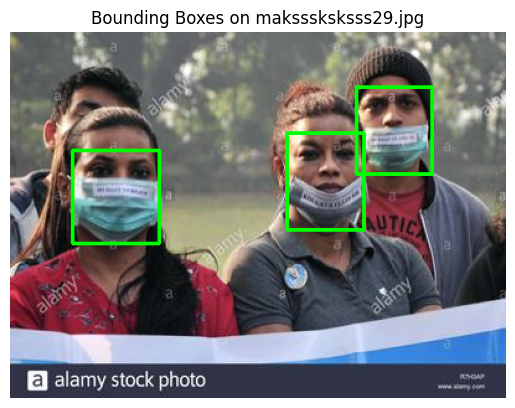

In [9]:
label_dir = "C:/NaqibWorks/project/Yolo/dataset/labels"
image_dir = "C:/NaqibWorks/project/Yolo/dataset/images"

def visualize_bboxes(img_path, label_path):
    img = cv2.imread(img_path)
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.split()
            x_center, y_center, width, height = map(float, parts[1:])
            img_height, img_width = img.shape[:2]
            x1 = int((x_center - width / 2) * img_width)
            y1 = int((y_center - height / 2) * img_height)
            x2 = int((x_center + width / 2) * img_width)
            y2 = int((y_center + height / 2) * img_height)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return img

# Visualize images with bounding boxes
img_name = "maksssksksss29.jpg"  # Replace with your image name
img_path = os.path.join(image_dir, img_name)
label_path = os.path.join(label_dir, img_name.replace('.jpg', '.txt'))
img_with_bboxes = visualize_bboxes(img_path, label_path)

plt.imshow(cv2.cvtColor(img_with_bboxes, cv2.COLOR_BGR2RGB))
plt.title(f"Bounding Boxes on {img_name}")
plt.axis('off')
plt.show()


## Check for duplicate or redundant

In [10]:
import hashlib

image_dir = "C:/NaqibWorks/project/Yolo/dataset/images"
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

def get_image_hash(img_path):
    img = cv2.imread(img_path)
    img_hash = hashlib.md5(cv2.imencode('.jpg', img)[1]).hexdigest()
    return img_hash

image_hashes = {}
duplicates = []

for img_name in image_files:
    img_path = os.path.join(image_dir, img_name)
    img_hash = get_image_hash(img_path)
    if img_hash in image_hashes:
        duplicates.append(img_name)
    else:
        image_hashes[img_hash] = img_name

if duplicates:
    print("Duplicate images found:", duplicates)
else:
    print("No duplicate images found.")


Duplicate images found: ['maksssksksss219.jpg', 'maksssksksss428.jpg', 'maksssksksss690.jpg', 'maksssksksss737.jpg', 'maksssksksss775.jpg']


## Aspect Ratio Analysis
Check whether the aspect ratios of the images are consistent. Highly skewed images (e.g., images with extreme width-to-height ratios) may lead to poor performance.

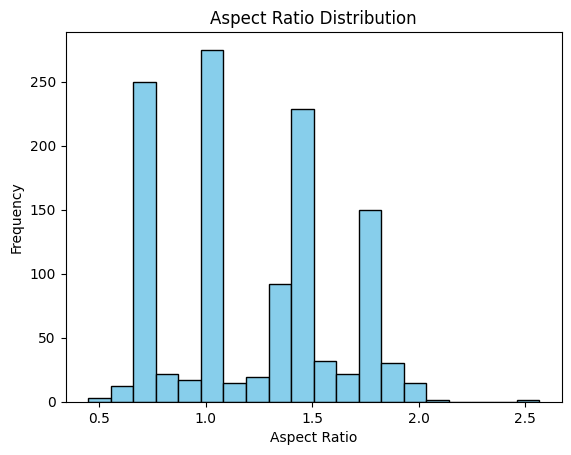

In [11]:
import os
import matplotlib.pyplot as plt
import cv2

image_dir = "C:/NaqibWorks/project/Yolo/dataset/images"
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

aspect_ratios = []

for img_name in image_files:
    img_path = os.path.join(image_dir, img_name)
    img = cv2.imread(img_path)
    height, width = img.shape[:2]
    aspect_ratio = width / height
    aspect_ratios.append(aspect_ratio)

plt.hist(aspect_ratios, bins=20, color='skyblue', edgecolor='black')
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()


## Class Imbalance Check
If your dataset is imbalanced, it may negatively impact model training. While you already checked class distribution, it's important to visualize the imbalances.

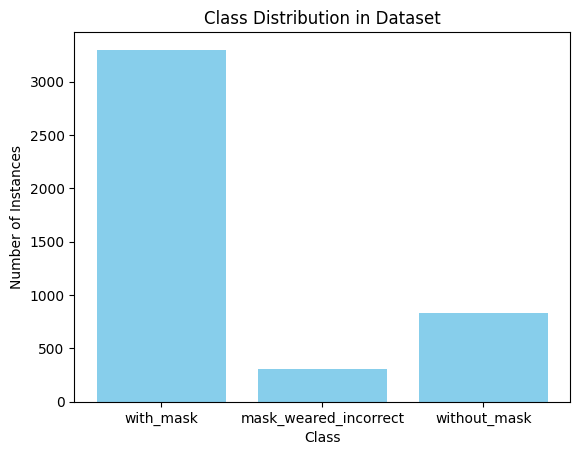

In [12]:

# Set paths to your image and label directories
image_dir = "C:/NaqibWorks/project/Yolo/dataset/images"
label_dir = "C:/NaqibWorks/project/Yolo/dataset/labels"

# List all label files
label_files = [f for f in os.listdir(label_dir) if f.endswith(".txt")]

# Initialize a dictionary to count instances of each class
class_counts = {0: 0, 1: 0, 2: 0}  # Assuming you have 3 classes: with_mask, mask_weared_incorrect, without_mask

# Count instances per class
for label_file in label_files:
    with open(os.path.join(label_dir, label_file), 'r') as file:
        for line in file:
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

# Class names for the bar plot
class_names = ["with_mask", "mask_weared_incorrect", "without_mask"]

# Plotting the class distribution
plt.bar(class_names, class_counts.values(), color='skyblue')
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.show()


## Sample Image from Each Class

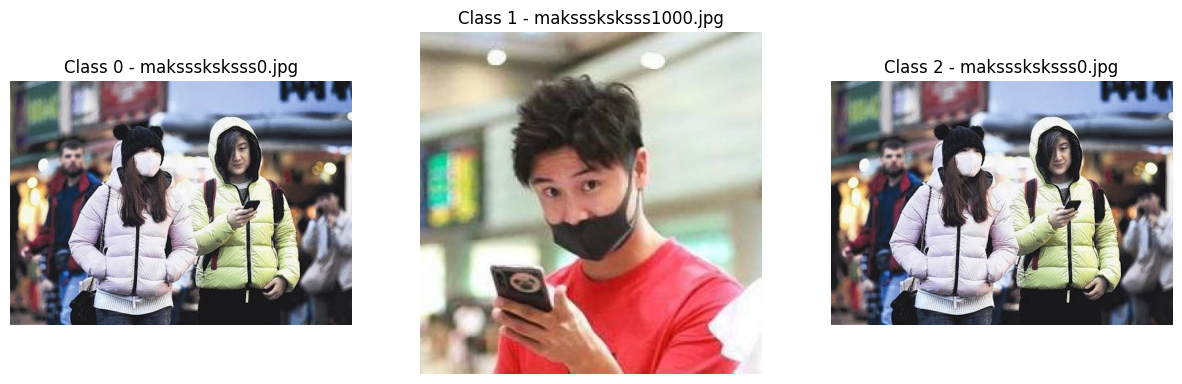

In [14]:
import random

# Set paths to your image and label directories
image_dir = "C:/NaqibWorks/project/Yolo/dataset/images"
label_dir = "C:/NaqibWorks/project/Yolo/dataset/labels"

# Function to load images and their labels
def load_image_and_label(class_id):
    label_files = [f for f in os.listdir(label_dir) if f.endswith(".txt")]
    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            for line in file:
                # Check if the current label belongs to the desired class
                if int(line.split()[0]) == class_id:
                    img_name = label_file.replace('.txt', '.jpg')
                    img_path = os.path.join(image_dir, img_name)
                    img = cv2.imread(img_path)
                    return img, img_name
    return None, None

# Randomly choose a sample from each class and display
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, class_id in enumerate([0, 1, 2]):  # Assuming 3 classes: 0, 1, and 2
    img, img_name = load_image_and_label(class_id)
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Class {class_id} - {img_name}")
    axes[i].axis('off')

plt.show()


## Bounding Box Example from Image

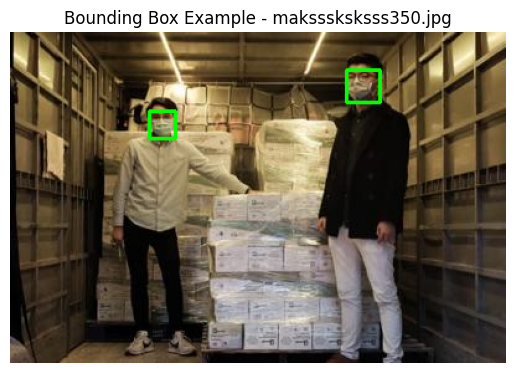

In [15]:

# Set paths to your image and label directories
image_dir = "C:/NaqibWorks/project/Yolo/dataset/images"
label_dir = "C:/NaqibWorks/project/Yolo/dataset/labels"

# Function to load an image and its annotations
def load_image_and_annotations(image_name):
    img_path = os.path.join(image_dir, image_name)
    img = cv2.imread(img_path)
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt'))

    # Read the labels (bounding boxes)
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.split()
            class_id = int(parts[0])
            # Get the bounding box coordinates
            x_center, y_center, width, height = map(float, parts[1:])
            img_height, img_width = img.shape[:2]

            # Convert to pixel values
            x1 = int((x_center - width / 2) * img_width)
            y1 = int((y_center - height / 2) * img_height)
            x2 = int((x_center + width / 2) * img_width)
            y2 = int((y_center + height / 2) * img_height)

            # Draw the bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return img

# Display an image with bounding boxes
img_name = random.choice(os.listdir(image_dir))
img = load_image_and_annotations(img_name)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Bounding Box Example - {img_name}")
plt.axis('off')
plt.show()


## Loading YOLO Model

There are lot of models available in yolo ranging from

- nano
- small
- medium
- large
- xl

**the weights and biases in models are different so their accuracy may vary but smaller models are fast with low latency**

In [16]:
from ultralytics import YOLO

# Load YOLOv8 Model
model = YOLO("yolov8s.pt") # 'n' version is lightweight, use 's', 'm', 'l' for larger models
print("YOLOv8 is ready!")

# nano
# model = YOLO('yolov8n.pt')

# small
# model = YOLO('yolov8s.pt') 

# medium
# model = YOLO('yolov8m.pt')

# large
# model = YOLO('yolov8l.pt')

# xl
# model = YOLO('yolov8x.pt')

YOLOv8 is ready!


## **YOLOv8 Model Training**

### **1. Training Parameters**
Below are the key parameters used for training the YOLOv8 model:

- **Epochs** → Number of training cycles.
- **Image Size (`imgsz`)** → Defines input image resolution.
- **Batch Size (`batch`)** → Number of images per training step.
- **Workers (`workers`)** → Number of CPU workers for data loading.
- **Learning Rate (`lr`)** → Controls model update speed.
- **Momentum** → Helps optimize weight updates.
- **Weight Decay** → Regularization to prevent overfitting.
- **Device (`device`)** → Automatically detects GPU (`cuda`) or CPU.
  
### **2. Device Selection**
The model automatically detects and selects:
- **CUDA (GPU)** → If available, accelerates training.
- **CPU** → Used when GPU is unavailable.

### **3. Optimizer Options**
The training process supports multiple optimizers:
- **SGD** → Stochastic Gradient Descent.
- **Adam** → Adaptive Momentum Estimation.
- **AdamW** *(Default)* → Adam with weight decay.
- **RMSprop** → Root Mean Square Propagation.

By default, **YOLOv8 uses AdamW** for optimal performance.


In [17]:
# Step 2: Verify device (CUDA or CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Train the Model

In [ ]:
# Train the model with optimized hyperparameters
results = model.train(
    data="C:/NaqibWorks/project/Yolo/dataset.yaml",  # Dataset config
    epochs=100,       # Train for 100 epochs
    imgsz=640,        # Higher image size for better accuracy
    batch=8,         # Adjust batch size based on GPU
    optimizer="AdamW", # Optimizer
    lr0=0.0015,       # Initial learning rate
    weight_decay=0.0005, # Regularization
    patience=0,      # Stop training if no improvement # 0 means disable early stopped
    device=device,    # Use GPU if available
    val=True,         # Enable validation
    save=True,        # Save model weights
    save_period=10    # Save model every 10 epochs
)


# Training complete message
print("🎯 Training Completed! Model is saved in 'runs' folder directory.")

Ultralytics 8.3.94  Python-3.13.2 torch-2.6.0+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:/NaqibWorks/project/Yolo/dataset.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=cpu, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

train: Scanning C:\NaqibWorks\project\Yolo\dataset\train\labels.cache... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\NaqibWorks\project\Yolo\dataset\val\labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<?, ?it/s]

Plotting labels to runs\detect\train2\labels.jpg... 


optimizer: AdamW(lr=0.0015, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.565      1.577      1.307         44        640: 100%|██████████| 43/43 [07:14<00:00, 10.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.67s/it]

                   all         85        564      0.638      0.276      0.261       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.318      1.046      1.171         83        640: 100%|██████████| 43/43 [07:06<00:00,  9.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.62s/it]

                   all         85        564      0.833      0.386      0.448      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.286     0.9657      1.154         47        640: 100%|██████████| 43/43 [06:53<00:00,  9.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.57s/it]

                   all         85        564      0.642      0.481       0.51      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.285      0.935      1.156         41        640: 100%|██████████| 43/43 [07:03<00:00,  9.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.65s/it]

                   all         85        564      0.562      0.523      0.533      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.255     0.8787      1.117         82        640: 100%|██████████| 43/43 [07:02<00:00,  9.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.62s/it]

                   all         85        564      0.652      0.532      0.568      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.181     0.8328      1.098         61        640: 100%|██████████| 43/43 [07:07<00:00,  9.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.94s/it]

                   all         85        564      0.539      0.531      0.539      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.225     0.8545      1.109         71        640: 100%|██████████| 43/43 [07:22<00:00, 10.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.88s/it]

                   all         85        564       0.73      0.533      0.606      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.206     0.7846      1.098        116        640: 100%|██████████| 43/43 [07:22<00:00, 10.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.91s/it]

                   all         85        564      0.746      0.538      0.572      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.181      0.795      1.089         51        640: 100%|██████████| 43/43 [07:22<00:00, 10.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.71s/it]

                   all         85        564      0.711      0.533      0.594      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.161     0.7656      1.081         62        640: 100%|██████████| 43/43 [07:09<00:00,  9.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.74s/it]

                   all         85        564      0.734      0.612      0.641      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.157     0.7403      1.064         63        640: 100%|██████████| 43/43 [07:02<00:00,  9.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.60s/it]

                   all         85        564      0.681      0.639      0.664      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.148     0.7252      1.072         91        640: 100%|██████████| 43/43 [07:02<00:00,  9.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.57s/it]

                   all         85        564      0.772      0.632      0.672      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.125     0.7125      1.083         52        640: 100%|██████████| 43/43 [07:04<00:00,  9.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.69s/it]

                   all         85        564      0.895      0.607      0.712      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G       1.12     0.6909      1.052         68        640: 100%|██████████| 43/43 [07:08<00:00,  9.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.75s/it]

                   all         85        564      0.745      0.625      0.688       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.115     0.6972      1.057        113        640: 100%|██████████| 43/43 [06:59<00:00,  9.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.59s/it]

                   all         85        564      0.886      0.619      0.684      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G        1.1      0.669      1.045         83        640: 100%|██████████| 43/43 [07:01<00:00,  9.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.66s/it]

                   all         85        564      0.801       0.64      0.685      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.081     0.6514      1.043         79        640: 100%|██████████| 43/43 [06:58<00:00,  9.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.71s/it]

                   all         85        564      0.731      0.646      0.666      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.073     0.6524      1.033         60        640: 100%|██████████| 43/43 [07:03<00:00,  9.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.72s/it]

                   all         85        564       0.89      0.616       0.71      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.069     0.6416      1.045         55        640: 100%|██████████| 43/43 [06:56<00:00,  9.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.63s/it]

                   all         85        564      0.776      0.622      0.701      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.074     0.6341      1.042         44        640: 100%|██████████| 43/43 [07:03<00:00,  9.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.66s/it]

                   all         85        564       0.89      0.629      0.734      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.054     0.6244      1.026         71        640: 100%|██████████| 43/43 [07:01<00:00,  9.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.63s/it]

                   all         85        564      0.767      0.615      0.709      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.061      0.621      1.018         84        640: 100%|██████████| 43/43 [07:00<00:00,  9.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.64s/it]

                   all         85        564        0.7       0.58       0.64      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.054     0.6244      1.018         88        640: 100%|██████████| 43/43 [06:58<00:00,  9.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.57s/it]

                   all         85        564        0.9      0.573      0.662       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.034     0.6189      1.019         62        640: 100%|██████████| 43/43 [07:01<00:00,  9.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.56s/it]

                   all         85        564      0.712      0.664      0.674      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.038     0.6051      1.016         40        640: 100%|██████████| 43/43 [06:57<00:00,  9.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.55s/it]

                   all         85        564      0.917      0.618      0.717      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.063     0.6016      1.012         47        640: 100%|██████████| 43/43 [06:59<00:00,  9.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.64s/it]

                   all         85        564      0.824      0.608      0.705      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.037      0.593      1.016         55        640: 100%|██████████| 43/43 [07:02<00:00,  9.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.60s/it]

                   all         85        564      0.797      0.649      0.699      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.024     0.5763       1.01         75        640: 100%|██████████| 43/43 [06:57<00:00,  9.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.55s/it]

                   all         85        564      0.829      0.615      0.696       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.016     0.5765       1.01         50        640: 100%|██████████| 43/43 [06:56<00:00,  9.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.64s/it]

                   all         85        564      0.919      0.648      0.738      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G       1.02      0.558      1.001        102        640: 100%|██████████| 43/43 [07:04<00:00,  9.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.75s/it]

                   all         85        564      0.865      0.671       0.74      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.005     0.5583      1.011         88        640: 100%|██████████| 43/43 [06:59<00:00,  9.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.65s/it]

                   all         85        564      0.896      0.622      0.728      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      0.991     0.5438     0.9889         41        640: 100%|██████████| 43/43 [07:02<00:00,  9.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.68s/it]

                   all         85        564      0.923      0.624      0.718      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.007     0.5469      1.006         98        640: 100%|██████████| 43/43 [06:59<00:00,  9.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.60s/it]

                   all         85        564      0.827      0.658      0.749      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.007     0.5509      0.996         77        640: 100%|██████████| 43/43 [06:54<00:00,  9.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.55s/it]

                   all         85        564      0.861      0.652       0.74      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G     0.9853     0.5448     0.9916        132        640: 100%|██████████| 43/43 [07:05<00:00,  9.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.74s/it]

                   all         85        564      0.821      0.626      0.726      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.9615     0.5391     0.9841         40        640: 100%|██████████| 43/43 [07:01<00:00,  9.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.74s/it]

                   all         85        564      0.871      0.616      0.732      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.9746     0.5333     0.9956        125        640: 100%|██████████| 43/43 [06:57<00:00,  9.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.63s/it]

                   all         85        564      0.899      0.666      0.751      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      0.992     0.5343     0.9867         46        640: 100%|██████████| 43/43 [07:00<00:00,  9.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.67s/it]

                   all         85        564      0.859      0.676       0.74      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.9663     0.5239     0.9782        184        640: 100%|██████████| 43/43 [07:00<00:00,  9.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.63s/it]

                   all         85        564      0.887      0.694       0.77        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.9646     0.5298     0.9855         43        640: 100%|██████████| 43/43 [06:56<00:00,  9.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.64s/it]

                   all         85        564      0.826      0.676      0.742      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.9586     0.5164     0.9872         69        640: 100%|██████████| 43/43 [07:00<00:00,  9.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.66s/it]

                   all         85        564      0.935      0.594       0.73      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.9584     0.5105     0.9781         87        640: 100%|██████████| 43/43 [07:05<00:00,  9.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.72s/it]

                   all         85        564      0.907      0.606      0.748      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.9632     0.5297      0.977         64        640: 100%|██████████| 43/43 [07:04<00:00,  9.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.71s/it]

                   all         85        564      0.896      0.617      0.734      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.9305     0.4986     0.9623         78        640: 100%|██████████| 43/43 [06:59<00:00,  9.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.65s/it]

                   all         85        564      0.862      0.632      0.729      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.9239     0.4936     0.9658         70        640: 100%|██████████| 43/43 [06:59<00:00,  9.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.68s/it]

                   all         85        564       0.89      0.681       0.73      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.9403     0.4997     0.9867         65        640: 100%|██████████| 43/43 [07:05<00:00,  9.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.78s/it]

                   all         85        564      0.885      0.631      0.741      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.9204     0.4948     0.9655         62        640: 100%|██████████| 43/43 [07:07<00:00,  9.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.75s/it]

                   all         85        564      0.906      0.645      0.727      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.9071     0.4905     0.9613         97        640: 100%|██████████| 43/43 [07:08<00:00,  9.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.68s/it]

                   all         85        564       0.91       0.64      0.746      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.9117     0.4907     0.9601         42        640: 100%|██████████| 43/43 [07:04<00:00,  9.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.70s/it]

                   all         85        564      0.853      0.651      0.726      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.9164     0.4839     0.9585         52        640: 100%|██████████| 43/43 [07:03<00:00,  9.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.65s/it]

                   all         85        564      0.908      0.623      0.718       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.9161     0.4827     0.9578         44        640: 100%|██████████| 43/43 [07:04<00:00,  9.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.68s/it]

                   all         85        564      0.915      0.656      0.742      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      0.911     0.4742      0.956         83        640: 100%|██████████| 43/43 [07:03<00:00,  9.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.86s/it]

                   all         85        564      0.871      0.632      0.718      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.9049     0.4724     0.9586         50        640: 100%|██████████| 43/43 [07:20<00:00, 10.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.31s/it]

                   all         85        564      0.832      0.645      0.735      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.9125     0.4725     0.9492         59        640: 100%|██████████| 43/43 [07:04<00:00,  9.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.59s/it]

                   all         85        564      0.894      0.601      0.735      0.477
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 39, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



54 epochs completed in 6.619 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 22.5MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.94  Python-3.13.2 torch-2.6.0+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.43s/it]


                   all         85        564      0.891      0.694       0.77        0.5
             with_mask         75        459      0.943      0.797      0.895       0.59
 mask_weared_incorrect         15         20       0.96        0.5      0.617      0.416
          without_mask         29         85      0.769      0.783      0.797      0.495
Speed: 2.5ms preprocess, 146.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\train2
🎯 Training Completed! Model is saved in 'runs/train' directory.


## Evaluate Model Performance

In [10]:
# Load the trained YOLOv8 model
model = YOLO("C:/NaqibWorks/project/Yolo/runs/detect/train2/weights/best.pt")

# Run validation on the dataset
metrics = model.val()

# Print evaluation metrics
print(metrics)

Ultralytics 8.3.94  Python-3.13.2 torch-2.6.0+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning C:\NaqibWorks\project\Yolo\dataset\val\labels.cache... 85 images, 0 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


                   all         85        564      0.886      0.697       0.77      0.499
             with_mask         75        459      0.941      0.804      0.896      0.591
 mask_weared_incorrect         15         20      0.949        0.5      0.617      0.411
          without_mask         29         85      0.768      0.788      0.798      0.494
Speed: 1.4ms preprocess, 130.1ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001AE80547230>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,

## Check Training Result

In [12]:
# Set path to your last training experiment
train_exp_path = "C:/NaqibWorks/project/Yolo/runs/detect/train2/exp"

# Display training results graph
results_img = os.path.join(train_exp_path, "test1.jpg")
img = plt.imread(results_img)
plt.figure(figsize=(10, 5))
plt.imshow(img)
plt.axis("off")
plt.title("Training Performance Graph")
plt.show()

<Figure size 1000x500 with 1 Axes>

## Test Model on an Image

In [13]:
# Test on multiple images
image_folder = "C:/NaqibWorks/project/Yolo/dataset/test"
results = model(image_folder)

# Show results
for result in results:
    result.show()  # Display each image with detections
    
    
    

# # Load your trained model
# model = YOLO("C:/NaqibWorks/project/Yolo/runs/detect/train/weights/best.pt")

# # Path to the image you want to test
# image_path = "C:/NaqibWorks/project/Yolo/dataset/test/test1.jpg"

# # Run inference
# results = model(image_path)

# # Show results
# results[0].show()  # Display the image with detected bounding boxes



image 1/4 C:\NaqibWorks\project\Yolo\dataset\test\test1.jpg: 256x640 7 with_masks, 1 mask_weared_incorrect, 1 without_mask, 117.3ms
image 2/4 C:\NaqibWorks\project\Yolo\dataset\test\test2.jpg: 448x640 2 with_masks, 137.9ms
image 3/4 C:\NaqibWorks\project\Yolo\dataset\test\test3.jpg: 448x640 1 mask_weared_incorrect, 1 without_mask, 97.7ms
image 4/4 C:\NaqibWorks\project\Yolo\dataset\test\test4.jpg: 384x640 1 without_mask, 127.3ms
Speed: 1.9ms preprocess, 120.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


tensorboard --logdir=C:/NaqibWorks/project/Yolo/runs/train
